# Milestone II

By Spencer Cheung, Phuc Nguyen, Joey Higgins

### Overview

The purpose of our project is to determine if it is possible to predict a neighboring country's foreign exchange (fx) return rate based on an anchoring country's foreign exchange trends. 

- H0: There is no relationship between anchoring and neighboring country's foreign exchange returns.

- H1: There is a causal relationship between anchoring and neighboring country foreign exchange returns.

### Sections

- Importing Data

- Cleaning Data

- Exploring Data

- Feature Engineering

### Assumptions

- We are looking at "Exchange Rates" on a quarterly basis

- We are using "Geography", "Frequency of Trade Between Two Nations", and "Amount of Trade in USD Between Two Nations" (we can also make a network using "Outflow" and "Inflow" and use "Page Rank" to determine)

- We are using "GDP Amount" to tie break between two countries, whichever has the higher GDP is the "Powerful Neighbor"

- JH - NX and Frequency Stats and Region

### TODO

- We need to determine more scientific how to set neighboring countries to powerful neighbors (i.e. k-means clustering, network analysis, we can look at the frequency and amount of trade between countries etc.)

- Need to determine which columns we want to keep

- We need to consistently determine the period (years)    

- We need to consistently determine the frequency (annual, monthly, weekly)

- We will use PCA and K-means clustering to confirm our initial grouping of "Neighboring Nations"

### Importing Packages

In [1]:
# !pip install networkx
# !pip install country_converter

In [2]:
# Importing packages
import country_converter as coco
import networkx as nx
import pandas as pd
import numpy as np
import warnings
import plotly
import glob
import csv
import os
import re

# Ignorning warnings
# warnings.filterwarnings("ignore")

### Defining Custom Functions

In [3]:
# Preprocessing column names to standardize
def standardize_column_names(dataframe):
    dataframe.columns = [
        str(column).lower().replace(" ", "_").replace(",", "")
        for column in dataframe.columns
    ]
    return dataframe


# assert list(standardize_column_names(pd.DataFrame(columns=['Test_0', 'teSt,_1']))) == ['test_0', 'test_1']

Importing Data

In [4]:
# # Viewing/Assessing the raw file(s) with linux shell (instead of importing via Python)
# !head -10 ./milestone-ii/imf_gdp_0.csv
# !head -10 ./milestone-ii/imf_exchange_rates_0.csv
# !head -10 ./milestone-ii/imf_exchange_rates_0.csv | head -1 | tr ',' '\n' | sed 's/"//g'
# !awk -F',"' '{print $4}' ./milestone-ii/imf_exchange_rates_0.csv | sort | uniq

In [35]:
# Importing Real GDP Purchasing Power Parity
# # Ranking; 1 = big country per region
country_gdp = pd.read_csv("/work/real_gdp_purchasing_power_parity.csv")
country_gdp.head(5)

# Exploring datatypes
country_gdp.dtypes

name                   object
slug                   object
value                  object
date_of_information     int64
ranking                 int64
region                 object
dtype: object

In [38]:
# Importing Fred Anchors

df_fred_world_gdp = pd.read_csv("/work/milestone-ii/fred_anchors_0.csv")
df_fred_world_gdp["observation_date"] = pd.to_datetime(
    df_fred_world_gdp["observation_date"]
)
df_fred_world_gdp["time_period"] = df_fred_world_gdp["observation_date"].dt.year
df_fred_world_gdp = df_fred_world_gdp.drop(columns=["observation_date"])
df_fred_world_gdp = df_fred_world_gdp.rename(columns={"NYGDPMKTPCDWLD": "world_gdp"})
df_fred_world_gdp.head()

,world_gdp,time_period
0,1.366519e+12,1960
1,1.444156e+12,1961
2,1.545552e+12,1962
3,1.671283e+12,1963
4,1.832063e+12,1964


In [41]:
# PHUC: are we sure this is the GDP dataset? The value and indicator type seems weird.


# Importing GDP
df_imf_gdp = pd.read_csv(
    "./milestone-ii/imf_gdp_0.csv",
    on_bad_lines="skip",
    sep=",",
    quoting=csv.QUOTE_ALL,
    skipinitialspace=True,
    usecols=[
        "COUNTRY",
        "TIME_PERIOD",
        "TYPE_OF_TRANSFORMATION",
        "FREQUENCY",
        "OBS_VALUE",
        "INDICATOR",
    ],
    #          quotechar='"',
    #          nrows=10,
    engine="python",
)
# Viewing data types
# df_imf_gdp.info()

# Viewing first five rows
df_imf_gdp.head()

,COUNTRY,INDICATOR,TYPE_OF_TRANSFORMATION,FREQUENCY,TIME_PERIOD,OBS_VALUE
0,Vietnam,Euros per domestic currency,End-of-period (EoP),Annual,1975,NaN
1,Vietnam,Euros per domestic currency,End-of-period (EoP),Annual,1985,NaN
2,Vietnam,Euros per domestic currency,End-of-period (EoP),Annual,1992,NaN
3,Vietnam,Euros per domestic currency,End-of-period (EoP),Annual,1999,0.000071
4,Vietnam,Euros per domestic currency,End-of-period (EoP),Annual,2000,0.000074


In [42]:
# # Importing Exchange Rates
# df_imf_trade_iter = pd.read_csv("./milestone-ii/imf_trade_0.csv",
#                                 sep=',',
#                                 engine="c",
#                                 encoding="utf-8-sig",   # handles BOM if present
#                                 quotechar='"',
#                                 doublequote=True,       # "" inside a quoted field
#                                 escapechar="\\",        # \" if the source escaped quotes that way
#                                 on_bad_lines="skip",     # drop any truly malformed records
#                                 # skipinitialspace=True,
#                                 # quoting=1,
#                                 usecols=["COUNTRY", "COUNTERPART_COUNTRY", "TIME_PERIOD", "OBS_VALUE", "TRADE_FLOW", "SCALE", "UNIT"],
#                                 # engine='python',
#                                 iterator=True,
#                                 chunksize=25_000)

# df_imf_trade_rate = pd.concat([chunk[chunk['FREQUENCY'] == "Quarterly"] for chunk in df_imf_trade_iter])
# df_imf_trade = pd.concat([chunk[chunk['FREQUENCY'] == "Annual"] for chunk in df_imf_trade_iter])

# Viewing data types
# df_imf_trade.info()

# Viewing first five rows
# df_imf_trade.head()

In [43]:
# Importing Exchange Rates
df_imf_trade = pd.read_csv(
    "./milestone-ii/imf_trade_0.csv",
    usecols=[
        "COUNTRY",
        "COUNTERPART_COUNTRY",
        "TIME_PERIOD",
        "OBS_VALUE",
        "TRADE_FLOW",
        "SCALE",
        "UNIT",
    ],
)
# (Manual) "Exclusion List"
ls_0 = [
    "World",
    "Advanced Economies",
    "Latin America and the Caribbean (LAC)",
    "Hong Kong Special Administrative Region, People's Republic of China",
    "Emerging and Developing Europe",
    "Middle East and Central Asia",
    "Emerging Market and Developing Economies",
    "Euro Area (EA)",
    "Emerging and Developing Asia",
]

# Excluding the "Exclusion List"
df_imf_trade = df_imf_trade[
    (~df_imf_trade["COUNTRY"].isin(ls_0))
    & (~df_imf_trade["COUNTERPART_COUNTRY"].isin(ls_0))
]

# Viewing first five rows
df_imf_trade = standardize_column_names(df_imf_trade).sort_values(
    by=["obs_value"], ascending=False
)
df_imf_trade.head()

# df_imf_trade['year'] = df_imf_trade['time_period'].apply(lambda x: str(x).split("-")[0])
# df_imf_trade_annual = df_imf_trade.groupby(['country', 'counterpart_country', 'year'])[['country', 'counterpart_country', 'year', 'obs_value']].sum()
# df_imf_trade_annual
# # df_imf_trade.head(2)

,country,counterpart_country,time_period,obs_value,scale,trade_flow,unit
400545,"China, People's Republic of",United States,2021-Q4,1.651331e+11,Millions,Exports of goods,US dollar
400544,"China, People's Republic of",United States,2021-Q3,1.590074e+11,Millions,Exports of goods,US dollar
400548,"China, People's Republic of",United States,2022-Q3,1.558462e+11,Millions,Exports of goods,US dollar
400547,"China, People's Republic of",United States,2022-Q2,1.542070e+11,Millions,Exports of goods,US dollar
400557,"China, People's Republic of",United States,2024-Q4,1.430223e+11,Millions,Exports of goods,US dollar


Review above, OK.

### Cleaning Data

In [56]:
# Cleaning df_imf_gdp
# # Filtering to the columns we want
# # Filtering to the measurements we want
"""df_imf_gdp_ = standardize_column_names(df_imf_gdp)[
            (df_imf_gdp['indicator'] == 'US Dollar per domestic currency') & 
            (~df_imf_gdp['obs_value'].isna()) &
            (df_imf_gdp['type_of_transformation'] == 'End-of-period (EoP)') &
            (df_imf_gdp['frequency'] == 'Annual')
    ].rename(columns={'time_period': 'year'}) \
     .sort_values(by=['country','year']) \
     .drop(columns=['indicator','type_of_transformation','frequency']) \
     .reset_index(drop=True)"""

# minor update
df_imf_gdp_ = (
    standardize_column_names(df_imf_gdp)
    .query(
        "indicator == 'US Dollar per domestic currency' "
        "and type_of_transformation == 'End-of-period (EoP)' "
        "and frequency == 'Annual'"
    )
    .dropna(subset=["obs_value"])
    .rename(columns={"time_period": "year"})
    .assign(year=lambda d: d["year"].str[:4])
    .sort_values(["country", "year"])
    .drop(columns=["indicator", "type_of_transformation", "frequency"])
    .reset_index(drop=True)
)


# df_imf_gdp_['year'] = df_imf_gdp_['year'].apply(lambda x: x.split('-')[0])


# minor changes to abvove to reduce null etc.
df_imf_gdp_ = df_imf_gdp_.assign(
    year=lambda d: pd.to_datetime(d["year"], errors="coerce").dt.year
)

In [11]:
# PHUC: Is there a reason why everything here is commented out? Have this cleaned DF be export somewhere?

# Cleaning df_imf_gdp
# # Filtered to "Annual" on import
# # Filtering to the columns we want
# # Filtering to the measurements we
# df_imf_trade_ = standardize_column_names(df_imf_trade)

# Cleaning country names
# df_imf_trade_['country'] = df_imf_trade_['country'].apply(lambda x: x.split(",")[0])
# df_imf_trade_['counterpart_country'] = df_imf_trade_['counterpart_country'].apply(lambda x: x.split(",")[0])

# Excluding pegged countries
# # https://www.investopedia.com/terms/c/currency-peg.asp

# df_imf_exchange_rate_ = df_imf_exchange_rate_[
#     ~df_imf_exchange_rate_['country'].isin(["Aruba", "Bahama", "Bahrain",
#                                             "Barbados","Belize","Bermuda",
#                                             "Cayman Islands","Cuba",
#                                             "Djiboutia","East Caribbea","Salvador",
#                                             "Eritrea","Hong Kong","Jordan",
#                                             "Kuwait","Lebanon","Antillea",
#                                             "Oman","Panamanian Balbo","Qatar",
#                                             "Saud","United Arab Emirates","Venezuelan"])
# ] # will need to do fuzzy matching here, on both counterpart

# # Feature engineering
df_imf_trade["obs_value_log"] = np.log10(df_imf_trade["obs_value"])
# df_imf_exchange_rate_['obs_value_prior'] = df_imf_exchange_rate_['obs_value'].shift(1, fill_value=0)
# df_imf_exchange_rate_['obs_value_prior_log'] = np.log10(df_imf_exchange_rate_['obs_value_prior'])
# df_imf_exchange_rate_ = standardize_column_names(pd.get_dummies(df_imf_exchange_rate_, columns=['indicator', 'country', 'counterpart_country'], dtype=int))
# df_imf_exchange_rate_ = df_imf_exchange_rate_[df_imf_exchange_rate_.dtypes.sort_values().index]
# df_imf_exchange_rate_
# df_imf_exchange_rate_.head()

### Exploring Data

In [12]:
## TESTING

import pandas as pd, networkx as nx

# 1) Prep (2021 only) + aggregate weights
df = standardize_column_names(df_imf_trade)
df = df[df["time_period"].astype(str).str[:4] == "2021"]
edges = (
    df.groupby(["counterpart_country", "country"], as_index=False)["obs_value"]
    .sum()
    .rename(
        columns={"counterpart_country": "src", "country": "dst", "obs_value": "weight"}
    )
)

# 2) Build graph + importance
G = nx.from_pandas_edgelist(
    edges, source="src", target="dst", edge_attr="weight", create_using=nx.DiGraph()
)
pr = nx.pagerank(G, weight="weight")
anchors = sorted(pr, key=pr.get, reverse=True)[:3]

# 3) Per-anchor neighbors (both directions), ranked by edge weight
rows = []
for a in anchors:
    nbrs = set(G.successors(a)) | set(G.predecessors(a))
    for n in nbrs:
        w = G[a][n]["weight"] if G.has_edge(a, n) else G[n][a]["weight"]
        rows.append((a, n, pr.get(n, 0.0), w))

df_neighbors = (
    pd.DataFrame(rows, columns=["anchor", "neighbor", "neighbor_importance", "weight"])
    .sort_values(
        ["anchor", "weight", "neighbor_importance"], ascending=[True, False, False]
    )
    .reset_index(drop=True)
)
df_neighbors[df_neighbors["neighbor_importance"] >= 0.02]

,anchor,neighbor,neighbor_importance,weight
0,"China, People's Republic of",Japan,0.028423,1.635989e+11
1,"China, People's Republic of","Korea, Republic of",0.025781,1.629130e+11
2,"China, People's Republic of",United States,0.068286,1.514319e+11
4,"China, People's Republic of",Germany,0.063346,1.237154e+11
7,"China, People's Republic of",Russian Federation,0.022820,6.842267e+10
9,"China, People's Republic of",Sub-Saharan Africa (SSA),0.028760,6.451405e+10
14,"China, People's Republic of","Netherlands, The",0.035495,3.776337e+10
18,"China, People's Republic of",France,0.024295,2.843571e+10
25,"China, People's Republic of",Italy,0.024251,1.851323e+10
35,"China, People's Republic of",Belgium,0.021457,9.430214e+09


In [13]:
# The error indicates that the lists 'ls_4', 'ls_2', and 'ls_3' are not of the same length.
# This is likely because 'ls_4' is not being populated in the loop.
# Let's fix this by appending the anchor to 'ls_4_a' in the loop.

# Fixing the code

df_imf_trade_ = standardize_column_names(df_imf_trade)
df_imf_trade_ = df_imf_trade_[
    df_imf_trade_["time_period"].apply(lambda x: str(x).split("-")[0]) == "2021"
]
G = nx.from_pandas_edgelist(
    df_imf_trade_.groupby(["counterpart_country", "country"], as_index=False)[
        "obs_value"
    ].sum(),
    source="counterpart_country",
    target="country",
    edge_attr="obs_value",
)
centrality = nx.eigenvector_centrality(G, weight="obs_value", max_iter=400)

labels = {}
for key, value in centrality.items():
    if value > 0.29:
        labels[key] = key.split(",")[0]
    else:
        labels[key] = ""

# Get top 3 nodes by centrality
dct_0 = sorted(centrality.items(), key=lambda item: item[1], reverse=True)[:3]
ls_0 = [i[0] for i in dct_0]

ls_2 = []
ls_3 = []
ls_4 = []
for i in ls_0:
    ls_1 = sorted(
        G.edges(i, data=True), key=lambda x: x[2].get("obs_value", 0.0), reverse=True
    )

    ls_2_a = []
    ls_3_a = []
    ls_4_a = []
    for j in ls_1:
        nbr = j[1] if j[0] == i else j[0]
        ls_2_a.append(nbr)
        ls_3_a.append(centrality.get(nbr, 0.0))
        ls_4_a.append(i)  # Append the anchor to ls_4_a

    ls_2.append(ls_2_a)
    ls_3.append(ls_3_a)
    ls_4.append(ls_4_a)

# Flatten the lists
ls_2 = [item for sublist in ls_2 for item in sublist]
ls_3 = [item for sublist in ls_3 for item in sublist]
ls_4 = [item for sublist in ls_4 for item in sublist]

# Create DataFrame
df_0 = pd.DataFrame(
    {"anchor": ls_4, "neighbor": ls_2, "neighbor_eigenvector_centrality": ls_3}
)
result = (
    df_0[df_0["neighbor_eigenvector_centrality"] >= 0.10]
    .sort_values(["anchor", "neighbor_eigenvector_centrality"], ascending=False)
    .reset_index(drop=True)
)
result

,anchor,neighbor,neighbor_eigenvector_centrality
0,United States,"China, People's Republic of",0.525836
1,United States,Mexico,0.259707
2,United States,Canada,0.224973
3,United States,Germany,0.219403
4,United States,Japan,0.194395
5,United States,"Korea, Republic of",0.163239
6,United States,United Kingdom,0.130448
7,United States,"Netherlands, The",0.127201
8,United States,India,0.106101
9,Mexico,United States,0.582361


In [14]:
from itertools import chain

anchors = [
    n for n, _ in sorted(centrality.items(), key=lambda kv: kv[1], reverse=True)[:3]
]


def edge_iter(G, a):
    if G.is_directed():
        return chain(G.out_edges(a, data=True), G.in_edges(a, data=True))
    else:
        return ((a, v, G[a][v]) for v in G[a].keys())


rows = []
for a in anchors:
    for u, v, d in edge_iter(G, a):
        nbr = v if u == a else u
        # guard against label mismatches; skip if neighbor not in centrality
        c = centrality.get(nbr)
        if c is None:
            continue
        w = d.get("weight")  # don’t default to 0; keep visibility on missing weights
        rows.append((a, nbr, c, w))

df_0 = pd.DataFrame(
    rows, columns=["anchor", "neighbor", "neighbor_eigenvector_centrality", "weight"]
)

# If empty, report why instead of failing silently
if df_0.empty:
    print(
        "No rows: check directionality, missing weights, or anchor-neighbor label mismatch."
    )
else:
    # If many weights missing, fill AFTER audit (optional):
    df_0["weight"] = df_0["weight"].fillna(0.0)
    df_0 = (
        df_0.query("neighbor_eigenvector_centrality >= 0.10")  # relax if too aggressive
        .sort_values(
            ["anchor", "weight", "neighbor_eigenvector_centrality"],
            ascending=[True, False, False],
        )
        .reset_index(drop=True)
    )
df_0

,anchor,neighbor,neighbor_eigenvector_centrality,weight
0,"China, People's Republic of",United States,0.582361,0.0
1,"China, People's Republic of",Mexico,0.259707,0.0
2,"China, People's Republic of",Canada,0.224973,0.0
3,"China, People's Republic of",Germany,0.219403,0.0
4,"China, People's Republic of",Japan,0.194395,0.0
5,"China, People's Republic of","Korea, Republic of",0.163239,0.0
6,"China, People's Republic of",United Kingdom,0.130448,0.0
7,"China, People's Republic of","Netherlands, The",0.127201,0.0
8,"China, People's Republic of",India,0.106101,0.0
9,Mexico,United States,0.582361,0.0


In [15]:
# guys, going to change value from object to float
# let me know if yall think we dont need step

country_gdp["value"] = (
    country_gdp["value"].replace(r"[\$,]", "", regex=True).astype(float)
)
country_gdp.dtypes

name                    object
slug                    object
value                  float64
date_of_information      int64
ranking                  int64
region                  object
dtype: object

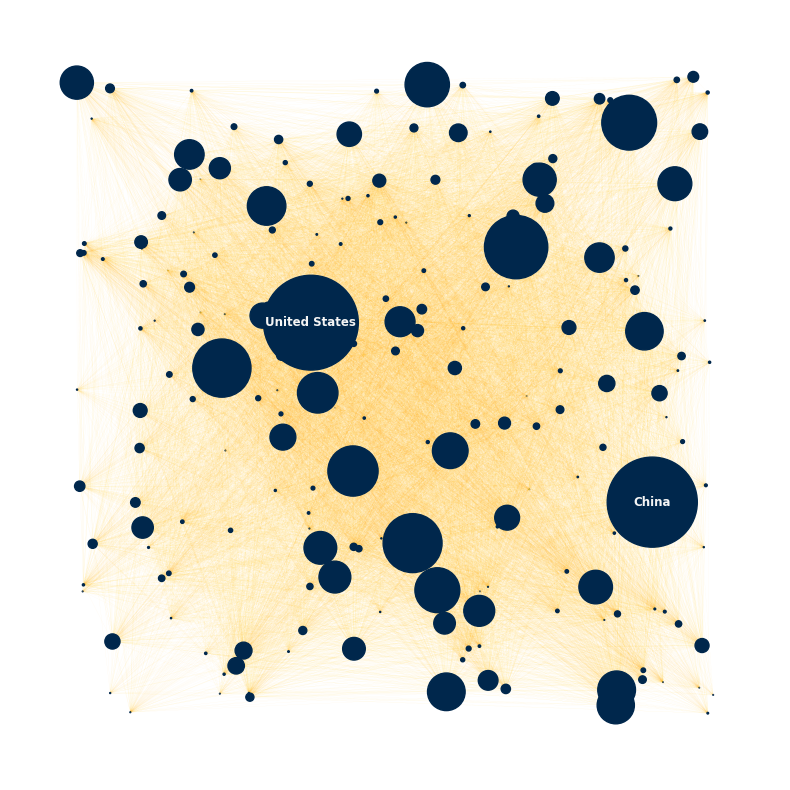

In [16]:
import matplotlib.pyplot as plt

# Correcting the error by converting dict_keys to a list

# nx.draw_random(
#         G,
#         nodelist=list(centrality.keys()),
#         node_size=[v * 20000 for v in centrality.values()],
#         node_color='#00274C',
#         alpha=.9,
#         width=.05,
#         with_labels=True,
#         labels=labels,
#         edge_color='#FFCB05',
#         font_size=9,
#         font_color="whitesmoke"
# )

plt.figure(3, figsize=(8, 8))
# kamada_kawai_layout
pos = nx.random_layout(
    G,
    # seed=3113794652
)

# nodes
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=list(centrality.keys()),
    node_size=[v * 8000 for v in centrality.values()],
    node_color="#00274C",
    alpha=1,
)

# edges
nx.draw_networkx_edges(G, pos, width=0.05, alpha=0.25, edge_color="#FFCB05")

nx.draw_networkx_labels(
    G, pos, labels=labels, font_size=8.5, font_color="whitesmoke", font_weight="bold"
)

plt.tight_layout()
plt.axis("off")
plt.show()

In [17]:
# going to check is there is na
country_gdp.isna().sum()

name                   0
slug                   0
value                  0
date_of_information    0
ranking                0
region                 0
dtype: int64

In [18]:
# going to do some light filtering, to be consider big per regrion
country_gdp["regional_rank"] = country_gdp.groupby("region")["value"].rank(
    ascending=False, method="first"
)


def tier_from_regional_rank(r):
    if r == 1:
        return "Big"
    elif r <= 5:
        return "Medium"
    else:
        return "Small"

In [19]:
country_gdp["tier"] = country_gdp["regional_rank"].apply(tier_from_regional_rank)
country_gdp

,name,slug,value,date_of_information,ranking,region,regional_rank,tier
0,China,china,3.359800e+13,2024,1,East and Southeast Asia,1.0,Big
1,United States,united-states,2.567600e+13,2024,2,North America,1.0,Big
2,India,india,1.424400e+13,2024,3,South Asia,1.0,Big
3,Russia,russia,6.089000e+12,2024,4,Central Asia,1.0,Big
4,Japan,japan,5.715000e+12,2024,5,East and Southeast Asia,2.0,Medium
...,...,...,...,...,...,...,...,...
216,Nauru,nauru,1.505810e+08,2024,217,Australia and Oceania,17.0,Small
217,Montserrat,montserrat,8.925400e+07,2024,218,Central America and the Caribbean,30.0,Small
218,Tuvalu,tuvalu,5.705500e+07,2023,219,Australia and Oceania,18.0,Small
219,Niue,niue,1.870000e+07,2021,220,Australia and Oceania,19.0,Small


In [20]:
# double checking for duplicates
country_gdp.duplicated(subset=["slug", "date_of_information"]).sum()

0

In [21]:
# wanted to confirm tiers should only have a big via this logic
# country_gdp.groupby('region')['tier'].value_counts()

In [22]:
# going to change tier from string to numeric
# big = 2, medium = 1, small = 0
country_gdp["tier_code"] = country_gdp["tier"].map({"Big": 2, "Medium": 1, "Small": 0})
# country_gdp

In [23]:
country_gdp.to_parquet("country_gdp_df.parquet")

PHUC'S CLEANING PORTION

In [24]:
# PHUC THIS IS THE START OF MY NOTTBOOK:
# PHUC: my data exploration. Might need a call to combine these somehow.


cc = coco.CountryConverter()
p = re.compile(
    r",\s*(?:Kingdom of the Netherlands|United Kingdom-British Overseas Territory|Republic of the|Union of the|State of the)$",
    re.I,
)


def clean(country):
    if pd.isna(country):
        return country
    country = str(country).strip()
    country = p.sub("", country)
    return re.sub(r",\s*The$", "", country, flags=re.I)


def short(country):
    if pd.isna(country):
        return pd.NA
    res = cc.convert(names=clean(country), to="name_short")
    if isinstance(res, (list, tuple)):
        res = res[0] if res else pd.NA
    if not res or res == "not found" or pd.isna(res):
        warnings.warn(f"Problem: {country}")
        return pd.NA
    return res


pegged = [
    "Aruba",
    "The Bahamas",
    "Bahrain",
    "Barbados",
    "Belize",
    "Bermuda",
    "Cayman Islands",
    "Cuba",
    "Djibouti",
    "Antigua and Barbuda",
    "Dominica",
    "Grenada",
    "Saint Kitts and Nevis",
    "Saint Lucia",
    "Saint Vincent and the Grenadines",
    "El Salvador",
    "Eritrea",
    "Hong Kong",
    "Jordan",
    "Kuwait",
    "Lebanon",
    "Curaçao",
    "Sint Maarten",
    "Oman",
    "Panama",
    "Qatar",
    "Saudi Arabia",
    "United Arab Emirates",
    "Venezuela",
]

pegged = {short(x) for x in pegged}
pegged.discard(pd.NA)

In [25]:
# PHUC GDP data

df_gdp = pd.read_csv("./milestone-ii/IMF_GDP_2.csv")

# filter to GDP in USD
df_gdp = df_gdp[
    df_gdp["INDICATOR"] == "Gross domestic product (GDP), Current prices, US dollar"
]
df_gdp["COUNTRY"] = df_gdp["COUNTRY"].map(short)
df_gdp = df_gdp.dropna(subset=["COUNTRY"])
df_gdp = df_gdp[["COUNTRY", "INDICATOR", "FREQUENCY", "2024"]]
df_gdp = df_gdp[~df_gdp["COUNTRY"].isin(pegged)]

df_gdp.head()
# df_gdp['COUNTRY'].unique()

# sorted df

df_gdp_sorted = df_gdp.sort_values(by="2024", ascending=False)
df_gdp_sorted.to_parquet("GDP_cleaned.parquet")
df_gdp_sorted.head(20)

World not found in regex
/tmp/ipykernel_219/2895135312.py:23: UserWarning: Problem: World
  warnings.warn(f"Problem: {country}")
Euro Area (EA) not found in regex
/tmp/ipykernel_219/2895135312.py:23: UserWarning: Problem: Euro Area (EA)
  warnings.warn(f"Problem: {country}")
Advanced Economies not found in regex
/tmp/ipykernel_219/2895135312.py:23: UserWarning: Problem: Advanced Economies
  warnings.warn(f"Problem: {country}")
Emerging Market and Developing Economies not found in regex
/tmp/ipykernel_219/2895135312.py:23: UserWarning: Problem: Emerging Market and Developing Economies
  warnings.warn(f"Problem: {country}")
ASEAN-5 not found in regex
/tmp/ipykernel_219/2895135312.py:23: UserWarning: Problem: ASEAN-5
  warnings.warn(f"Problem: {country}")
European Union (EU) not found in regex
/tmp/ipykernel_219/2895135312.py:23: UserWarning: Problem: European Union (EU)
  warnings.warn(f"Problem: {country}")
Emerging and Developing Asia not found in regex
/tmp/ipykernel_219/2895135312.py

,COUNTRY,INDICATOR,FREQUENCY,2024
10196,United States,"Gross domestic product (GDP), Current prices, ...",Annual,2.918490e+13
8783,China,"Gross domestic product (GDP), Current prices, ...",Annual,1.874801e+13
8981,Germany,"Gross domestic product (GDP), Current prices, ...",Annual,4.658526e+12
9262,Japan,"Gross domestic product (GDP), Current prices, ...",Annual,4.026211e+12
9157,India,"Gross domestic product (GDP), Current prices, ...",Annual,3.909097e+12
10138,United Kingdom,"Gross domestic product (GDP), Current prices, ...",Annual,3.644636e+12
9086,France,"Gross domestic product (GDP), Current prices, ...",Annual,3.162023e+12
9121,Italy,"Gross domestic product (GDP), Current prices, ...",Annual,2.372059e+12
8812,Canada,"Gross domestic product (GDP), Current prices, ...",Annual,2.241253e+12
8656,Brazil,"Gross domestic product (GDP), Current prices, ...",Annual,2.171337e+12


In [26]:
# PHUC trade flow data

df_trade = pd.read_csv("./milestone-ii/imf_trade_0.csv")

df_trade = df_trade[
    ["COUNTRY", "COUNTERPART_COUNTRY", "TIME_PERIOD", "OBS_VALUE", "TRADE_FLOW", "UNIT"]
]

df_trade["COUNTRY"] = df_trade["COUNTRY"].map(short)
df_trade["COUNTERPART_COUNTRY"] = df_trade["COUNTERPART_COUNTRY"].map(short)
df_trade = df_trade.dropna(subset=["COUNTRY", "COUNTERPART_COUNTRY"])
df_trade = df_trade[~df_trade["COUNTRY"].isin(pegged)]
df_trade = df_trade[~df_trade["COUNTERPART_COUNTRY"].isin(pegged)]
df_trade.to_parquet("trade_cleaned.parquet")
df_trade.head()

Euro Area (EA) not found in regex
/tmp/ipykernel_219/2895135312.py:23: UserWarning: Problem: Euro Area (EA)
  warnings.warn(f"Problem: {country}")
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Euro Area (EA) not found in regex
Eur

KeyboardInterrupt: 

In [62]:
# Spencer: Looks good, i cannot comment much about the network analysis because i hadn't taken any classes on that.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=619db6da-a06b-4834-b7df-60521a3a0b3a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>